# Adult Census Income Classification - Ludwig API

We recommend using a GPU runtime for this example. In the Colab menu bar, choose Runtime > Change Runtime Type and choose GPU under Hardware Accelerator.

In this notebook, we will show how to use the Ludwig CLI to:

1. Download a Dataset
1. Train a Ludwig Model
1. Evaluate the trained model
1. Visualize training and test metrics
1. Make predictions on New Data

In [1]:
# TODO: revert to ludwig-ai repo when issue #1885 fixed
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
#!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

!python -m pip install git+https://github.com/jimthompson5802/ludwig.git@fix-iss1885-roc-curve-viz-error  --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 136 kB 10.5 MB/s 
     |████████████████████████████████| 398 kB 71.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.8 MB/s 
     |████████████████████████████████| 271 kB 61.7 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 59.6 MB/s 


# Download Dataset

[Adult Census Income](https://archive.ics.uci.edu/ml/datasets/adult) is an extract of 1994 Census data for predicting whether a person's income exceeds $50K per year.  The data set consists of over 49K records with 14 attributes with missing data.


The columns in the dataset are

| column         | description                                                  |
|----------------|--------------------------------------------------------------|
| age            | numeric variable, age of person                              |
| workclass      | categorical variable, Type of empolyment                     |
| fnlwgt         | numeric variable, no defintion                               |
| education      | categorical variable, education level                        |
| education-num  | nmeric variable, no definition                               |
| marital-status | categorical variable, marital status                         |
| occupation     | categorical variable, occupation                             |
| relationship   | categorical variable, Relationship to household              |
| race           | categorical variable, race                                   |
| sex            | categorical variable, gender                                 |
| capital-gain   | numeric variable, no definition                              |
| capital-loss   | numeric variable, no definition                              |
| hours-per-week | numeric variable, hours worked per week                      |
| native-country | categorical variable, Country of origin                      |
| income         | binary variable, " <=50K" or " >50K"                         |
| split          | numeric variable, indicating data split training(0), test(2) |


In [2]:
from ludwig.datasets import adult_census_income

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = adult_census_income.load(split=True)

## Display sample training and testdata

In [5]:
import pandas as pd
import numpy as np

# setup pandas output options
pd.set_option('display.max_colwidth', 100)

# make reproducible output sample
np.random.seed(31)

# Print sample of trainig and test data sets.
print(f"Training Dataset(train_df):\n{train_df.sample(n=5)}")
print(f"\nTest Dataset(test_df):\n{test_df.sample(n=5)}")

Training Dataset(train_df):
       age   workclass  fnlwgt     education  education-num  \
24279   59   State-gov  349910     Bachelors             13   
8364    43           ?  142030       HS-grad              9   
25546   41     Private  207779       HS-grad              9   
6173    79     Private  120707     Doctorate             16   
29227   40   State-gov  141858   Prof-school             15   

            marital-status        occupation    relationship    race      sex  \
24279   Married-civ-spouse   Exec-managerial         Husband   White     Male   
8364              Divorced                 ?       Unmarried   White   Female   
25546            Separated     Other-service   Not-in-family   White   Female   
6173    Married-civ-spouse    Prof-specialty         Husband   White     Male   
29227   Married-civ-spouse    Prof-specialty         Husband   White     Male   

       capital-gain  capital-loss  hours-per-week  native-country  income  
24279         10605           

# Train

## Define ludwig config and create Ludwig model object

In [10]:
import logging
from ludwig.api import LudwigModel

# define model configuration
config = {'combiner': {'dropout': 0.2,
              'num_fc_layers': 3,
              'output_size': 128,
              'type': 'concat'},
 'input_features': [{'name': 'age', 'type': 'number'},
                    {'name': 'workclass', 'type': 'category'},
                    {'name': 'fnlwgt', 'type': 'number'},
                    {'name': 'education', 'type': 'category'},
                    {'name': 'education-num', 'type': 'number'},
                    {'name': 'marital-status', 'type': 'category'},
                    {'name': 'occupation', 'type': 'category'},
                    {'name': 'relationship', 'type': 'category'},
                    {'name': 'race', 'type': 'category'},
                    {'name': 'sex', 'type': 'category'},
                    {'name': 'capital-gain', 'type': 'number'},
                    {'name': 'capital-loss', 'type': 'number'},
                    {'name': 'hours-per-week', 'type': 'number'},
                    {'name': 'native-country', 'type': 'category'}],
 'output_features': [{'name': 'income',
                      'num_fc_layers': 4,
                      'output_size': 32,
                      'preprocessing': {'fallback_true_label': ' >50K'},
                      'type': 'binary'}],
 'preprocessing': {'number': {'missing_value_strategy': 'fill_with_mean',
                              'normalization': 'zscore'}},
 'trainer': {'epochs': 10, 'optimizer': {'type': 'adam'}}}

# instantiate Ludwig model object
model = LudwigModel(config=config, logging_level=logging.INFO)

# Train the model

In [11]:
# Trains the model. This cell might take a few minutes.
train_stats, preprocessed_data, output_directory = model.train(dataset=train_df)


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ ludwig_version   │ '0.5rc2'                                                                                │
├──────────────────┼─────────

# Evaluate

4

In [39]:
# Generates predictions and performance statistics for the test set.
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True,
  return_type='dict'
)

Evaluation: 100%|██████████| 128/128 [00:00<00:00, 208.84it/s]

===== income =====
accuracy: 0.7781463265419006
average_precision_macro: 0.2816030759737681
average_precision_micro: 0.2816030759737681
average_precision_samples: 0.2816030759737681
loss: 7131.49951171875
overall_stats: { 'avg_f1_score_macro': 0.5010492335429741,
  'avg_f1_score_micro': 0.7781463055094896,
  'avg_f1_score_weighted': 0.6972073767161714,
  'avg_precision_macro': 0.8317491624976324,
  'avg_precision_micro': 0.7781463055094896,
  'avg_precision_weighted': 0.7781463055094896,
  'avg_recall_macro': 0.5334742846891197,
  'avg_recall_micro': 0.7781463055094896,
  'avg_recall_weighted': 0.7781463055094896,
  'kappa_score': 0.09819924379169997,
  'token_accuracy': 0.7781463055094896}
per_class_stats: {False: {   'accuracy': 0.7781463055094896,
    'f1_score': 0.8728795664109242,
    'fall_out': 0.9303172126885075,
    'false_discovery_rate': 0.2239188935477815,
    'false_negative_rate': 0.0027342179332529026,
    '

In [43]:
predictions['income']['probabilities']

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [18]:
predictions.income_predictions.value_counts()

 <=50K    15979
 >50K       302
Name: income_predictions, dtype: int64

In [46]:
preprocessed_data[-1]

{'age': {'mean': 38.58164596557617,
  'preprocessing': {'computed_fill_value': 38.58164596557617,
   'fill_value': 0,
   'missing_value_strategy': 'fill_with_mean',
   'normalization': 'zscore'},
  'std': 13.64044189453125},
 'capital-gain': {'mean': 1077.649169921875,
  'preprocessing': {'computed_fill_value': 1077.649169921875,
   'fill_value': 0,
   'missing_value_strategy': 'fill_with_mean',
   'normalization': 'zscore'},
  'std': 7385.91162109375},
 'capital-loss': {'mean': 87.3038330078125,
  'preprocessing': {'computed_fill_value': 87.3038330078125,
   'fill_value': 0,
   'missing_value_strategy': 'fill_with_mean',
   'normalization': 'zscore'},
  'std': 403.0147705078125},
 'checksum': 'pfKwOmSFzupXrv73Wb19MA==',
 'data_train_hdf5_fp': '/content/7a2858dcb92b11ecb3df0242ac1c0002.training.hdf5',
 'education': {'idx2str': ['<UNK>',
   ' HS-grad',
   ' Some-college',
   ' Bachelors',
   ' Masters',
   ' Assoc-voc',
   ' 11th',
   ' Assoc-acdm',
   ' 10th',
   ' 7th-8th',
   ' Prof-

# Visualize Metrics

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
pd.DataFrame(predictions['income']['probabilities']).describe()

,0,1
count,16281.000000,16281.000000
mean,0.981451,0.018549
std,0.134931,0.134931
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


## ROC Curve

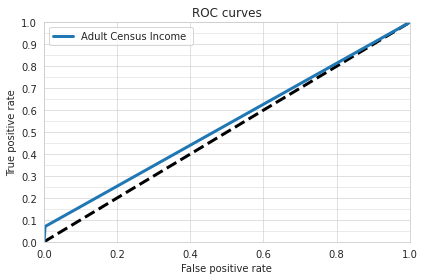

In [44]:
from ludwig.visualize import roc_curves

roc_curves(
    [predictions['income']['probabilities']],
    test_df['income'],
    preprocessed_data[-1],
    'income',
    '1',
    model_names=["Adult Census Income"],
    output_directory='visualization',
    file_format='png'
)